## Section one – LoRA, QLoRA and Memory Management ## 

### Derive LoRA ###
**“ Understand. Don't memorize. Learn principles, not formulas.” 
  	– Richard Feynman**

In summary,  “Low-Rank Adaptation, or LoRA, which freezes the pre-trained model weights and injects trainable rank decomposition matrices into each layer of the Transformer architecture, greatly reducing the number of trainable parameters for downstream tasks.” 

*TL;DR*
#### Intuition ####
**A)** Many of you have heard about compression techniques like QR decomposition, or Principle Component Analysis(PCA), connecting with the fact deep learning at its core involves many matrix multiplications. What if we replace full matrix multiplication by much smaller metrics that capture its ‘essence’? 
<br>**→** use lora_A@lora_B to ‘replace’ the original weights in each layer in some way. 
<br>**→** lora_A, lora_B is set to be size ‘rank’, where rank << original weights size. Just like what we do in PCA, we have the most efficient replication at rank=1, then rank=2, etc. As we increase rank, lora_A@lora_B will get closer to the original weights, but with diminishing returns.
<br>**→** use a scaling factor ```self.scaling = self.lora_alpha / self.rank```, to lora_A@lora_B, reduces the influence of each individual dimension in our low-rank approximation.

**B)** But we don’t want to actually perform QR decomposition in the midst of fine turning, that would introduce too much additional work! 
<br>**→** use learned weights lora_A, llora_B to **approximate** true mathematical decomposition.

```python
        # Initialize LoRA matrices
        self.lora_A = nn.Parameter(torch.zeros(original_layer.in_features, rank))
        self.lora_B = nn.Parameter(torch.zeros(rank, original_layer.out_features))
        Self.r = rank
        self.alpha = alpha
        self.scaling = self.lora_alpha / self.r
```

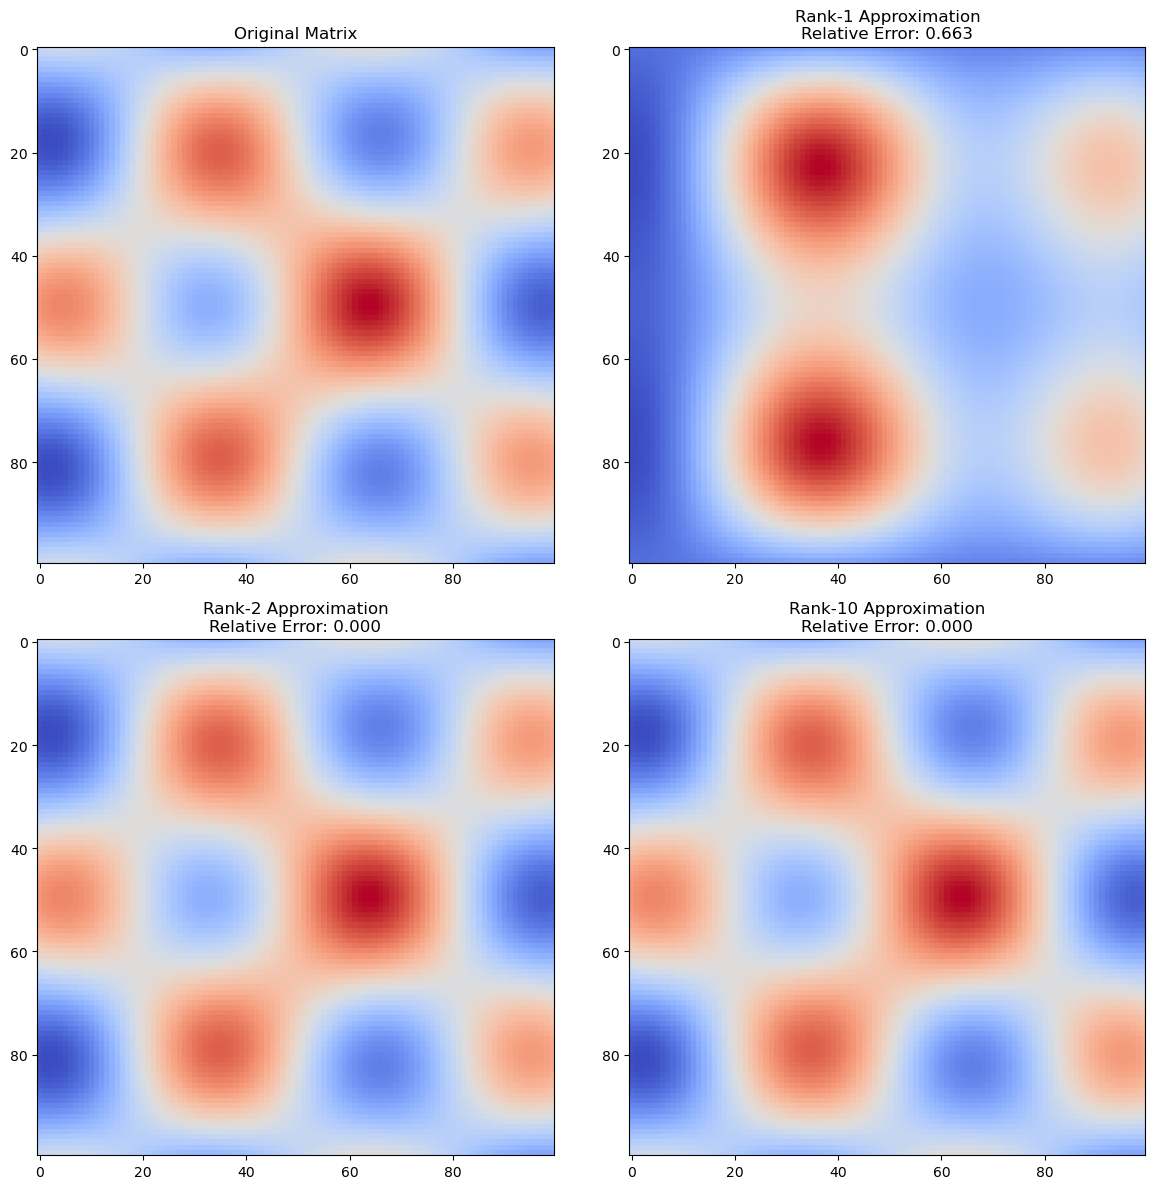

In [26]:
import numpy as np
import matplotlib.pyplot as plt

def visualize_rank_approximation():
    # Create a more complex sample matrix
    size = 100
    x = np.linspace(-5, 5, size)
    y = np.linspace(-5, 5, size)
    X, Y = np.meshgrid(x, y)
    # Create a matrix with more complex structure
    W = np.sin(X) * np.cos(Y) + np.exp(-(X**2 + Y**2)/20)
    
    # Compute SVD
    U, S, Vt = np.linalg.svd(W)
    
    # Plot original and different rank approximations
    fig, axes = plt.subplots(2, 2, figsize=(12, 12))
    axes[0,0].imshow(W, cmap='coolwarm')
    axes[0,0].set_title('Original Matrix')
    
    for r, ax in zip([1, 2, 10], axes.flat[1:]):
        # Low rank approximation
        W_approx = U[:,:r] @ np.diag(S[:r]) @ Vt[:r,:]
        ax.imshow(W_approx, cmap='coolwarm')
        error = np.linalg.norm(W - W_approx, 'fro') / np.linalg.norm(W, 'fro')
        ax.set_title(f'Rank-{r} Approximation\nRelative Error: {error:.3f}')
    
    plt.tight_layout()
    return None

visualize_rank_approximation()

#### LoRA design ####
**During training:**
1. Forward pass combines original and LoRA computations
2. Backward pass only computes gradients for LoRA matrices (A and B)
3. Optimizer updates only A and B
4. Original weights remain frozen throughout

This is all handled automatically by PyTorch's autograd system when we set requires_grad=False for original weights and use nn.Parameter for LoRA matrices

**A) Avoid updating the full weight matrix by freeze the original weights during training**
<br>**→**
```python
class LoRALayer(nn.Module):
    def __init__(self, original_layer, rank=4, alpha=1):
        super().__init__()
        self.original_layer = original_layer
        # Freeze original weights
        for param in self.original_layer.parameters():
            param.requires_grad = False
```

**B) Adding an additional trainable lora component during forward process, so that only A and B are updated**
   ```python
   def forward(x):
       # Original computation
       original_output = x @ W
       # LoRA computation
       lora_output = x @ (A @ B) * scaler
       # Combined output
       return original_output + lora_output
   ```

**C) During inference, the same addition serves as the "injection point" that connects LoRA metrics to the original weights**
<br>**→** ``` W_final = W_original + (A @ B) ```


#### LoRA memory efficiency ####
**A) Memory savings come from:** 
1. Not computing/storing gradients for frozen weights 
2. Optimizer states (like Adam's momentum/variance) only needed for LoRA matrices 
3. Smaller matrices for gradient computation

In [28]:
# adapter componets are designed to have few parameters, sometimes <1% of the original model
def analyze_memory_requirements(d_model=768, rank=8):
    # Original model memory
    original_params = d_model * d_model
    original_optimizer_state = 2 * original_params  # For Adam's momentum and variance
    
    # LoRA memory
    lora_params = d_model * rank + rank * d_model
    lora_optimizer_state = 2 * lora_params
    
    print(f"Original training memory: {(original_params + original_optimizer_state) * 4 / 1e6:.2f} MB")
    print(f"LoRA training memory: {(original_params + lora_params + lora_optimizer_state) * 4 / 1e6:.2f} MB")


analyze_memory_requirements()

Original training memory: 7.08 MB
LoRA training memory: 2.51 MB


#### LoRA Initialization ####
**A) Initialize the LoRA metrics for  training stability**
```python
    def reset_parameters(self):
        nn.Embedding.reset_parameters(self)
        if hasattr(self, 'lora_A'):
            # initialize A the same way as the default for nn.Linear and B to zero
            nn.init.zeros_(self.lora_A)
            nn.init.normal_(self.lora_B)
```

#### Putting everything together, we arrive the following simplified implementation ####

In [34]:
import torch.nn as nn

class LoRALayer(nn.Module):
    def __init__(self, original_layer, rank=4, alpha=1):
        super().__init__()
        self.original_layer = original_layer
        
        # Store dimensions
        self.in_features = original_layer.in_features
        self.out_features = original_layer.out_features
        
        # Freeze original weights
        for param in self.original_layer.parameters():
            param.requires_grad = False
        
        # Initialize LoRA matrices
        self.lora_A = nn.Parameter(torch.zeros(self.in_features, rank))
        self.lora_B = nn.Parameter(torch.zeros(rank, self.out_features))
        self.rank = rank 
        self.alpha = alpha
        self.scaling = self.alpha / self.rank 
        
        self.reset_parameters()
    
    def reset_parameters(self):
        # Initialize A with kaiming uniform (default for Linear layers)
        nn.init.kaiming_uniform_(self.lora_A, a=math.sqrt(5))
        # Initialize B to zero as per LoRA paper
        nn.init.zeros_(self.lora_B)
    
    def forward(self, x):
        # Original computation
        original_output = self.original_layer(x)
        # LoRA computation
        lora_output = (x @ self.lora_A @ self.lora_B) * self.scaling

        # When loss.backward() is called later:
        # 1. Gradients flow back through this addition
        # 2. original_layer.weight gets no gradients (requires_grad=False)
        # 3. lora_A and lora_B get gradients via chain rule
        return original_output + lora_output

### LoRA Memory Efficiency by Phase ###

**A) Loading Phase**:
   - Traditional: Full model (e.g., 7B params) + optimizer states
   - LoRA: Full model (frozen) + small LoRA matrices (<1% params)
   
**B) Forward Pass(Inference)**:
   - Both need full model in memory
   - LoRA adds minimal overhead for extra matrix multiplications
   
**C) Backward Pass (biggest savings)**:
   - Traditional: Gradients for all parameters
   - LoRA: Gradients only for LoRA matrices
   
**D) Optimization**:
   - Traditional: Update all parameters
   - LoRA: Update only LoRA matrices
   
<br>**Real-world Example (7B model)**:
- Traditional training might need: 7B × 4 bytes × 3 (weights + 2 Adam states) ≈ 84GB
- LoRA training might need: 7B × 4 bytes (frozen weights) + 7B × 0.01 × 4 bytes × 3 ≈ 28.84GB



#### Let us visualize the memory savings ####

Traditional training total memory: 9.54 MB
LoRA training total memory: 2.65 MB


<Figure size 640x480 with 0 Axes>

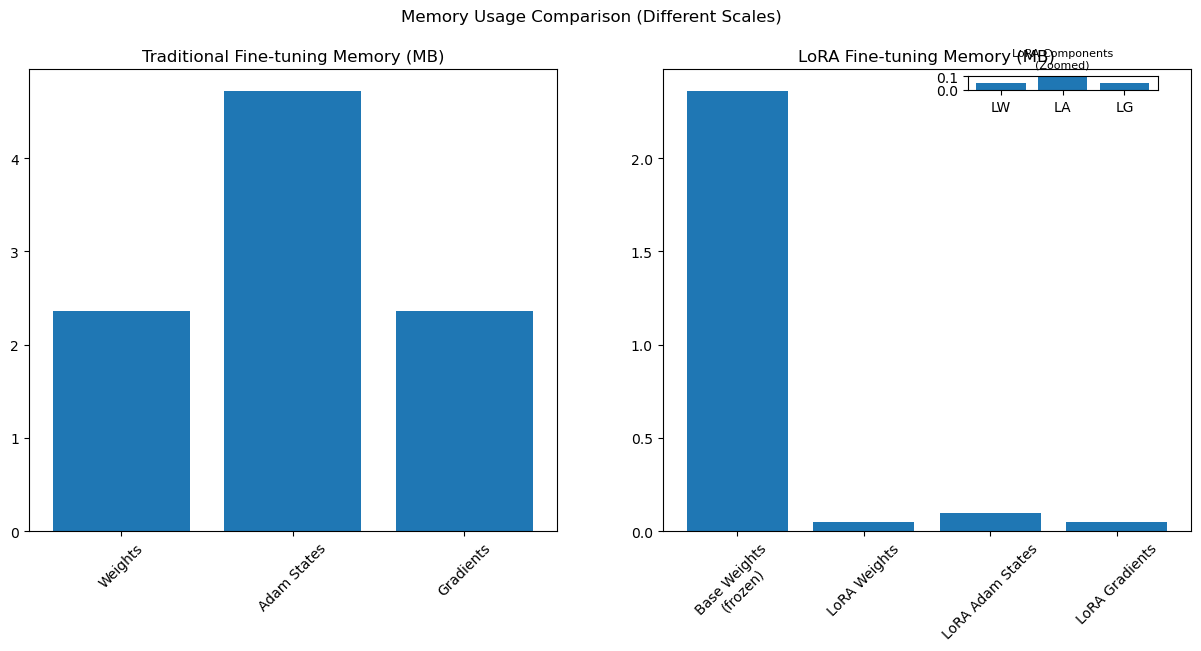

Traditional training total memory: 9.54 MB
LoRA training total memory: 2.65 MB


<Figure size 640x480 with 0 Axes>

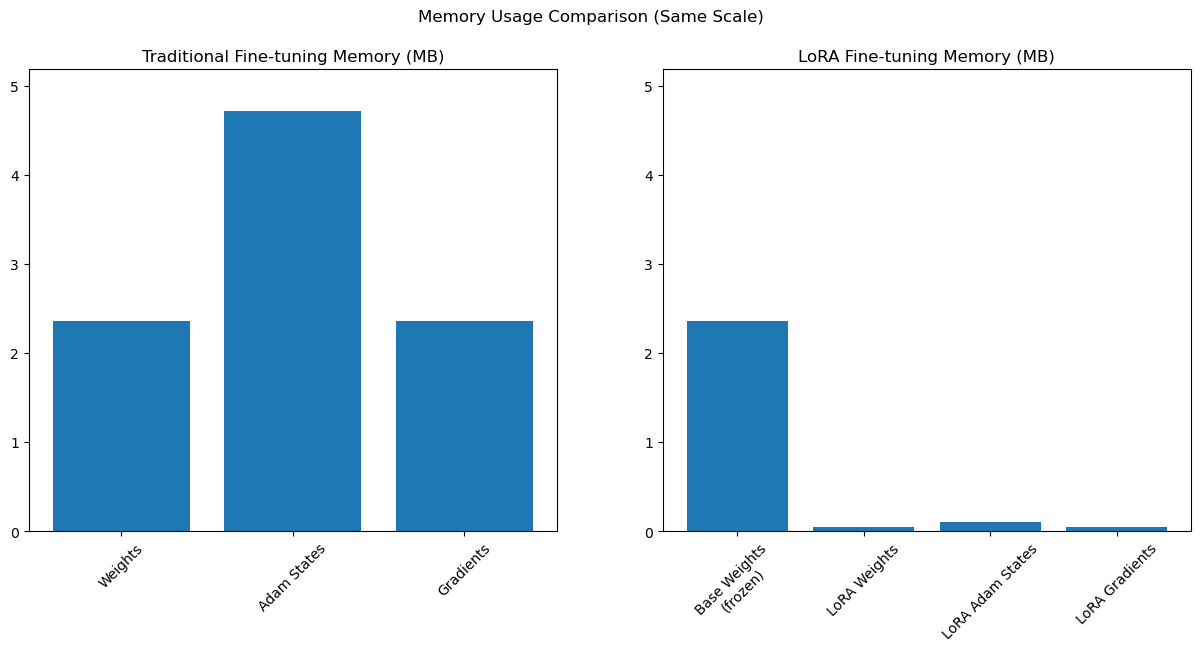

In [86]:
def analyze_training_memory(d_model=768, rank=8, same_scale=False):
    """
    Key Memory Savings in LoRA:
    
    1. During Forward Pass:
       Traditional: Load full weights (768x768)
       LoRA: Load full weights + small LoRA matrices (768x8 + 8x768)
       
    2. During Backward Pass:
       Traditional: Store gradients for all weights (768x768)
       LoRA: Only store gradients for LoRA matrices (768x8 + 8x768)
       
    3. Adam States:
       Traditional: 2 states × full weights (2 × 768x768)
       LoRA: 2 states × LoRA matrices (2 × (768x8 + 8x768))
    """
    # Calculate memory requirements
    batch_size = 32
    
    traditional = {
        'weights': d_model * d_model * 4,  # 4 bytes per float32
        'adam_states': 2 * d_model * d_model * 4,
        'gradients': d_model * d_model * 4,
        'activations': batch_size * d_model * 4
    }
    
    lora = {
        'base_weights': d_model * d_model * 4,  # frozen
        'lora_weights': (d_model * rank + rank * d_model) * 4,
        'adam_states': 2 * (d_model * rank + rank * d_model) * 4,
        'gradients': (d_model * rank + rank * d_model) * 4,
        'activations': batch_size * d_model * 4
    }
    
    # Print total memory requirements
    print(f"Traditional training total memory: {sum(traditional.values()) / 1e6:.2f} MB")
    print(f"LoRA training total memory: {sum(lora.values()) / 1e6:.2f} MB")

    plt.clf()  # Clear any existing plots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Traditional training
    trad_sizes = [traditional['weights'], traditional['adam_states'], 
                  traditional['gradients']]
    ax1.bar(['Weights', 'Adam States', 'Gradients'], 
            [size/1e6 for size in trad_sizes])
    ax1.set_title('Traditional Fine-tuning Memory (MB)')
    ax1.tick_params(axis='x', rotation=45)
    
    # LoRA training
    lora_sizes = [lora['base_weights'], lora['lora_weights'], 
                  lora['adam_states'], lora['gradients']]
    ax2.bar(['Base Weights\n(frozen)', 'LoRA Weights', 
             'LoRA Adam States', 'LoRA Gradients'],
            [size/1e6 for size in lora_sizes])
    ax2.set_title('LoRA Fine-tuning Memory (MB)')
    ax2.tick_params(axis='x', rotation=45)
    
    if same_scale:
        # Find the maximum y value across both plots
        y_max = max(max([size/1e6 for size in trad_sizes]), 
                   max([size/1e6 for size in lora_sizes]))
        ax1.set_ylim(0, y_max * 1.1)  # Add 10% padding
        ax2.set_ylim(0, y_max * 1.1)
        
        # Add a note about scale
        fig.suptitle('Memory Usage Comparison (Same Scale)', fontsize=12)
    else:
        # Add a note about different scales
        fig.suptitle('Memory Usage Comparison (Different Scales)', fontsize=12)
        
        # Maybe add an inset or zoomed view of the LoRA plot
        from mpl_toolkits.axes_grid1.inset_locator import inset_axes
        axins = inset_axes(ax2, width="40%", height="30%", 
                          bbox_to_anchor=(0.05, 0.9, 0.9, 0.1),
                          bbox_transform=ax2.transAxes)
        axins.bar(['LW', 'LA', 'LG'], 
                 [lora['lora_weights']/1e6, 
                  lora['adam_states']/1e6, 
                  lora['gradients']/1e6])
        axins.set_title('LoRA Components\n(Zoomed)', fontsize=8)
    
    plt.savefig('fig.png',bbox_inches='tight')
    return fig

# Usage
# With different scales (default)
fig1 = analyze_training_memory()
plt.show()

# With same scale
fig2 = analyze_training_memory(same_scale=True)
plt.show()

### LoRA Advantages ###

**A) Task Switching and Model Sharing**
<br>The base model acts like a foundation that can support multiple specialized "adapters" (LoRA modules) for different tasks. Think of it like having a versatile camera with interchangeable lenses - you keep one expensive camera body (pre-trained model) and switch between smaller, specialized lenses (LoRA modules) for different types of photography.

**B) Training Efficiency and Accessibility**
<br>As we demonstrated in our memory analysis, LoRA significantly reduces memory requirements during training:
- No gradient computation for base model
- Smaller optimizer states (Adam's momentum/variance)
- Less memory needed for backpropagation
This makes fine-tuning possible on consumer GPUs, democratizing access to model adaptation.

**C) Zero Inference Overhead**
<br>Remember our forward pass equation?
```python
output = original_output + lora_output  # During training
```
At deployment, we can simply merge the weights:
```python
W_final = W_original + (A @ B) * scaling  # One-time merge
output = x @ W_final  # During inference
```
This means no extra computations during inference!

**D) Composability with Other Methods**
<br>LoRA's simple design principle - adding a parallel low-rank path - means it can be combined with other techniques. It's like having a modular toolkit where LoRA is just one tool that plays well with others.
```

